In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('imdb_top_1000.csv')

In [4]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [5]:
df = df.dropna(subset=['Overview', 'IMDB_Rating'])

In [6]:
df['Label'] = (df['IMDB_Rating'] >= 8).astype(int)

In [7]:
texts = df['Overview'].astype(str)
labels = df['Label'].values

In [8]:
df['Label'].value_counts()

Label
0    537
1    463
Name: count, dtype: int64

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [10]:
vocab_size = 10000
max_len = 200

In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=max_len),
    tf.keras.layers.LSTM(128, return_sequences=False),   
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
25/25 [==============================] - 11s 221ms/step - loss: 0.7019 - accuracy: 0.5275 - val_loss: 0.6930 - val_accuracy: 0.4900
Epoch 2/5
25/25 [==============================] - 4s 171ms/step - loss: 0.7063 - accuracy: 0.5213 - val_loss: 0.6930 - val_accuracy: 0.5250
Epoch 3/5
25/25 [==============================] - 4s 170ms/step - loss: 0.6819 - accuracy: 0.5375 - val_loss: 0.6934 - val_accuracy: 0.5200
Epoch 4/5
25/25 [==============================] - 4s 170ms/step - loss: 0.6188 - accuracy: 0.6463 - val_loss: 0.6901 - val_accuracy: 0.5300
Epoch 5/5
25/25 [==============================] - 4s 170ms/step - loss: 0.4380 - accuracy: 0.8100 - val_loss: 0.6947 - val_accuracy: 0.5050


In [24]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)

7/7 [==============================] - 0s 65ms/step - loss: 0.6947 - accuracy: 0.5050
Test Accuracy: 0.5049999952316284


In [25]:
y_pred = model.predict(x_test).flatten()
y_pred = (y_pred > 0.5).astype(int)

7/7 [==============================] - 1s 62ms/step


In [26]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.70      0.61       109
           1       0.43      0.27      0.34        91

    accuracy                           0.51       200
   macro avg       0.48      0.49      0.47       200
weighted avg       0.49      0.51      0.48       200



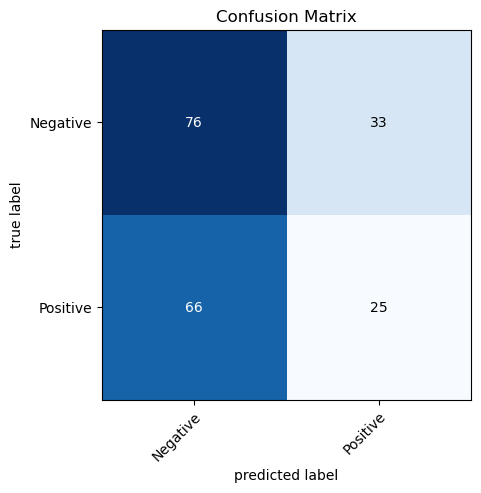

In [27]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.show()